In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 16.9 MB/s eta 0:00:00


In [12]:
!pip install --upgrade torch torchvision torchaudio


In [184]:
import os
import shutil
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ultralytics import YOLO
import hashlib
import matplotlib.image as mpimg
from torchvision import transforms

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Paths to your original KITTI dataset on Google Drive
original_images_train_path = '/content/drive/MyDrive/kitti_dataset/data_object_image_2/training/image_2'
original_images_test_path = '/content/drive/MyDrive/kitti_dataset/data_object_image_2/testing/image_2'
original_labels_path = '/content/drive/MyDrive/kitti_dataset/data_object_label_2/training'

# Paths to the new YOLO folder structure on Google Drive
yolo_images_train_path = '/content/drive/MyDrive/kitti_yolo/images/train'
yolo_images_val_path = '/content/drive/MyDrive/kitti_yolo/images/val'
yolo_images_test_path = '/content/drive/MyDrive/kitti_yolo/images/test'
yolo_labels_train_path = '/content/drive/MyDrive/kitti_yolo/labels/train'
yolo_labels_val_path = '/content/drive/MyDrive/kitti_yolo/labels/val'
yolo_labels_test_path = '/content/drive/MyDrive/kitti_yolo/labels/test'

# Created necessary folders for YOLO structure
os.makedirs(yolo_images_train_path, exist_ok=True)
os.makedirs(yolo_images_val_path, exist_ok=True)
os.makedirs(yolo_images_test_path, exist_ok=True)
os.makedirs(yolo_labels_train_path, exist_ok=True)
os.makedirs(yolo_labels_val_path, exist_ok=True)
os.makedirs(yolo_labels_test_path, exist_ok=True)

In [ ]:
# Dictionary to map KITTI classes to numeric labels (YOLO)
class_map = {
    'Car': 0, 'Pedestrian': 1, 'Van': 2, 'Cyclist': 3,
    'Truck': 4, 'Misc': 5, 'Tram': 6, 'Person_sitting': 7, 'DontCare': 8
}

In [ ]:
# Function to convert KITTI labels to YOLO format
def convert_kitti_to_yolo(label_path, output_path, image_width, image_height):
    with open(label_path, 'r') as f:
        lines = f.readlines()

    yolo_labels = []
    for line in lines:
        elements = line.strip().split()
        class_name = elements[0]

        if class_name in class_map and class_name != 'DontCare':
            class_id = class_map[class_name]
            x_min = float(elements[4])
            y_min = float(elements[5])
            x_max = float(elements[6])
            y_max = float(elements[7])

            # Convert KITTI bounding box to YOLO format
            x_center = ((x_min + x_max) / 2) / image_width
            y_center = ((y_min + y_max) / 2) / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height

            yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}\n")

    # Write the converted labels to the output file
    with open(output_path, 'w') as f:
        f.writelines(yolo_labels)

In [ ]:
# Loads image and label paths
image_files = sorted(os.listdir(original_images_train_path))
label_files = sorted(os.listdir(original_labels_path))

In [ ]:
# Check that the number of images matches the number of label files
if len(image_files) != len(label_files):
    raise ValueError("The number of images does not match the number of label files.")

In [ ]:
# Combine images and labels into a list of tuples
dataset = list(zip(image_files, label_files))

In [ ]:
train_set, temp_set = train_test_split(dataset, test_size=0.3, random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

In [ ]:
# Process the training and validation sets
for image_file, label_file in train_set:
    shutil.copy(os.path.join(original_images_train_path, image_file), os.path.join(yolo_images_train_path, image_file))
    label_path = os.path.join(original_labels_path, label_file)
    image_path = os.path.join(yolo_images_train_path, image_file)
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    output_label_path = os.path.join(yolo_labels_train_path, label_file)
    convert_kitti_to_yolo(label_path, output_label_path, image_width, image_height)

for image_file, label_file in val_set:
    shutil.copy(os.path.join(original_images_train_path, image_file), os.path.join(yolo_images_val_path, image_file))
    label_path = os.path.join(original_labels_path, label_file)
    image_path = os.path.join(yolo_images_val_path, image_file)
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    output_label_path = os.path.join(yolo_labels_val_path, label_file)
    convert_kitti_to_yolo(label_path, output_label_path, image_width, image_height)


In [6]:
#data.yaml file
data_yaml_content = """
train: /content/drive/MyDrive/kitti_yolo/images/train
val: /content/drive/MyDrive/kitti_yolo/images/val

nc: 8  # Number of classes
names: ['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'Person_sitting']
"""
with open('/content/drive/MyDrive/kitti_yolo/data.yaml', 'w') as file:
    file.write(data_yaml_content)

print("data.yaml file created")


data.yaml file created


In [7]:
# Loading the YOLOv8 model
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 254MB/s]


In [56]:
model.train(data='/content/drive/MyDrive/kitti_yolo/data.yaml', epochs=10, imgsz=640, batch=8, save=True)

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/kitti_yolo/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=KITTI_Object_Detection, name=exp26, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

train: Scanning /content/drive/MyDrive/kitti_yolo/labels/train.cache... 5236 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5236/5236 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/kitti_yolo/labels/val.cache... 1122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1122/1122 [00:00<?, ?it/s]


Plotting labels to KITTI_Object_Detection/exp26/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to KITTI_Object_Detection/exp26
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.57G      1.127      0.865      1.076         20        640: 100%|██████████| 655/655 [01:17<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.85it/s]


                   all       1122       6081      0.708      0.587      0.662      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.57G     0.9709     0.6586     0.9896         20        640: 100%|██████████| 655/655 [01:14<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.34it/s]

                   all       1122       6081      0.737      0.608      0.687      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       7.5G     0.9542     0.6339     0.9823         24        640: 100%|██████████| 655/655 [01:12<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.99it/s]

                   all       1122       6081      0.772      0.642      0.723      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      7.47G     0.9309     0.6061     0.9752         31        640: 100%|██████████| 655/655 [01:12<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.24it/s]

                   all       1122       6081      0.819      0.647      0.734        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.46G     0.9125     0.5854     0.9642         21        640: 100%|██████████| 655/655 [01:12<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.95it/s]

                   all       1122       6081      0.793      0.675      0.756      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.49G     0.8864     0.5608     0.9574         15        640: 100%|██████████| 655/655 [01:12<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.18it/s]

                   all       1122       6081      0.822      0.688      0.779      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.47G     0.8607     0.5359      0.949         12        640: 100%|██████████| 655/655 [01:12<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.80it/s]

                   all       1122       6081      0.854      0.681       0.79       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.47G     0.8415     0.5178     0.9387         17        640: 100%|██████████| 655/655 [01:12<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.24it/s]

                   all       1122       6081      0.836      0.729      0.805      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.49G     0.8171     0.4951      0.929         28        640: 100%|██████████| 655/655 [01:12<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.78it/s]

                   all       1122       6081      0.871      0.713      0.811       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       7.5G     0.7961     0.4816     0.9228         30        640: 100%|██████████| 655/655 [01:12<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:06<00:00, 10.49it/s]

                   all       1122       6081      0.905      0.712      0.821      0.591



10 epochs completed in 0.237 hours.
Optimizer stripped from KITTI_Object_Detection/exp26/weights/last.pt, 46.7MB
Optimizer stripped from KITTI_Object_Detection/exp26/weights/best.pt, 46.7MB

Validating KITTI_Object_Detection/exp26/weights/best.pt...
Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 236 layers, 23,207,464 parameters, 0 gradients, 67.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:09<00:00,  7.31it/s]


                   all       1122       6081      0.861      0.702      0.806      0.581
                   Car        994       4309      0.952      0.801      0.935      0.738
            Pedestrian        272        678      0.871      0.558      0.733      0.415
                   Van        326        448      0.871      0.824      0.893      0.685
               Cyclist        164        228      0.876      0.671      0.793      0.516
                 Truck        160        169      0.893      0.882      0.941      0.752
                  Misc        103        130      0.829      0.598      0.709      0.494
                  Tram         56         80      0.791      0.875      0.912      0.701
        Person_sitting         17         39      0.808       0.41      0.536      0.343
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to KITTI_Object_Detection/exp26


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3708265de0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [57]:
# Validate the model
metrics = model.val(data='/content/drive/MyDrive/kitti_yolo/data.yaml', conf=0.25, iou=0.5)
print(metrics)

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 236 layers, 23,207,464 parameters, 0 gradients, 67.5 GFLOPs


val: Scanning /content/drive/MyDrive/kitti_yolo/labels/val.cache... 1122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1122/1122 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [00:20<00:00,  6.93it/s]


                   all       1122       6081      0.846      0.745      0.839      0.633
                   Car        994       4309      0.946      0.835      0.917      0.764
            Pedestrian        272        678      0.886       0.63      0.782      0.477
                   Van        326        448      0.849       0.85      0.896      0.722
               Cyclist        164        228      0.838      0.724      0.825      0.575
                 Truck        160        169      0.871      0.911      0.945      0.787
                  Misc        103        130      0.789      0.663      0.776      0.569
                  Tram         56         80      0.847        0.9      0.935      0.739
        Person_sitting         17         39      0.745       0.45      0.636      0.429
Speed: 0.1ms preprocess, 5.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to KITTI_Object_Detection/exp262
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class

In [58]:
# Evaluate on the test set after training is complete
results = model.predict(source='/content/drive/MyDrive/kitti_yolo/images/test', conf=0.25, save=True, save_txt=True)

Streaming output truncated to the last 5000 lines.
image 2522/7518 /content/drive/MyDrive/kitti_yolo/images/test/002521.png: 224x640 1 Car, 32.9ms
image 2523/7518 /content/drive/MyDrive/kitti_yolo/images/test/002522.png: 224x640 1 Pedestrian, 32.4ms
image 2524/7518 /content/drive/MyDrive/kitti_yolo/images/test/002523.png: 224x640 2 Cars, 33.6ms
image 2525/7518 /content/drive/MyDrive/kitti_yolo/images/test/002524.png: 224x640 3 Cars, 1 Van, 34.3ms
image 2526/7518 /content/drive/MyDrive/kitti_yolo/images/test/002525.png: 224x640 1 Pedestrian, 33.2ms
image 2527/7518 /content/drive/MyDrive/kitti_yolo/images/test/002526.png: 224x640 4 Cars, 41.8ms
image 2528/7518 /content/drive/MyDrive/kitti_yolo/images/test/002527.png: 224x640 3 Cars, 35.0ms
image 2529/7518 /content/drive/MyDrive/kitti_yolo/images/test/002528.png: 224x640 2 Cars, 34.3ms
image 2530/7518 /content/drive/MyDrive/kitti_yolo/images/test/002529.png: 224x640 1 Car, 33.7ms
image 2531/7518 /content/drive/MyDrive/kitti_yolo/images/te

In [38]:
class_names = ['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'Person_sitting']


In [154]:
predicted_images_dir = 'KITTI_Object_Detection/exp263'
predicted_labels_dir = 'KITTI_Object_Detection/exp263/labels'
ground_truth_images_dir = '/content/drive/MyDrive/kitti_yolo/images/val'
ground_truth_labels_dir = '/content/drive/MyDrive/kitti_yolo/labels/val'
image_format = '.png'

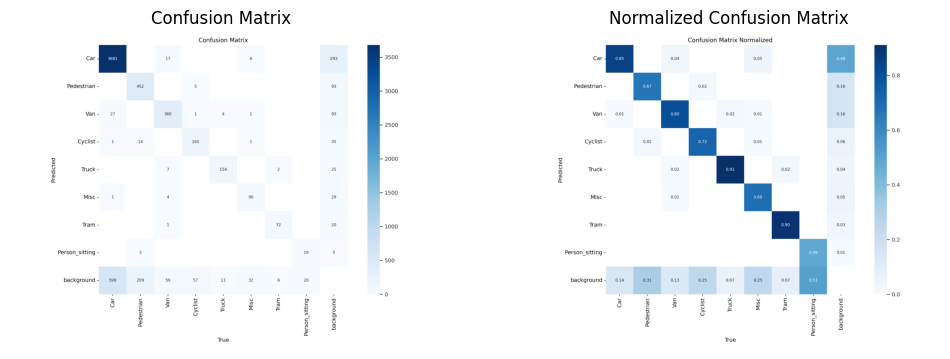

In [162]:
# Path to confusion matrix files
confusion_matrix_path = 'KITTI_Object_Detection/exp262/confusion_matrix.png'
normalized_confusion_matrix_path = 'KITTI_Object_Detection/exp262/confusion_matrix_normalized.png'

# Load and display the confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Normal confusion matrix
img = mpimg.imread(confusion_matrix_path)
ax[0].imshow(img)
ax[0].set_title('Confusion Matrix')
ax[0].axis('off')

# Normalized confusion matrix
img_normalized = mpimg.imread(normalized_confusion_matrix_path)
ax[1].imshow(img_normalized)
ax[1].set_title('Normalized Confusion Matrix')
ax[1].axis('off')

plt.show()


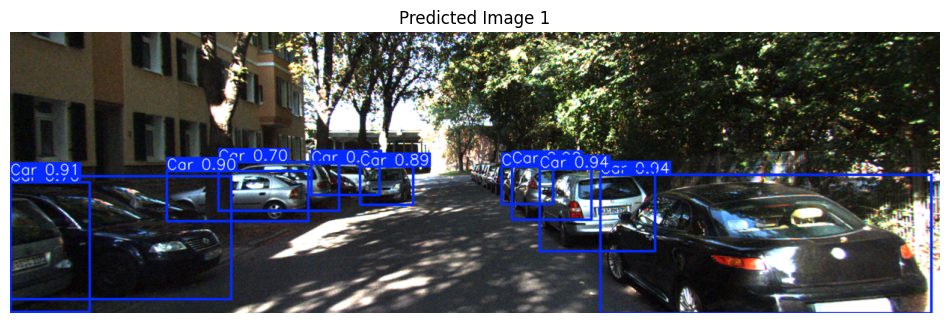

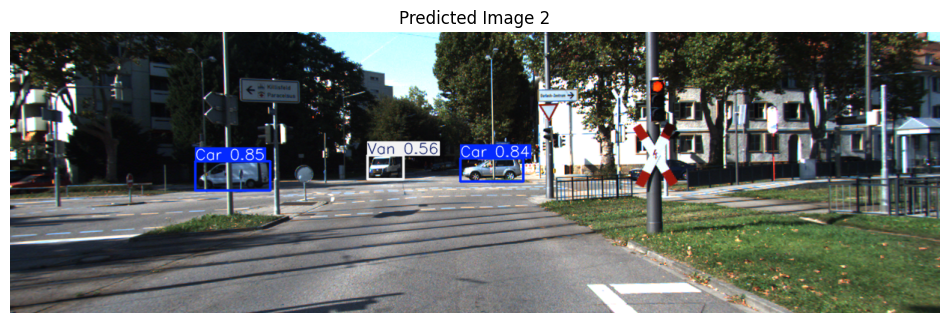

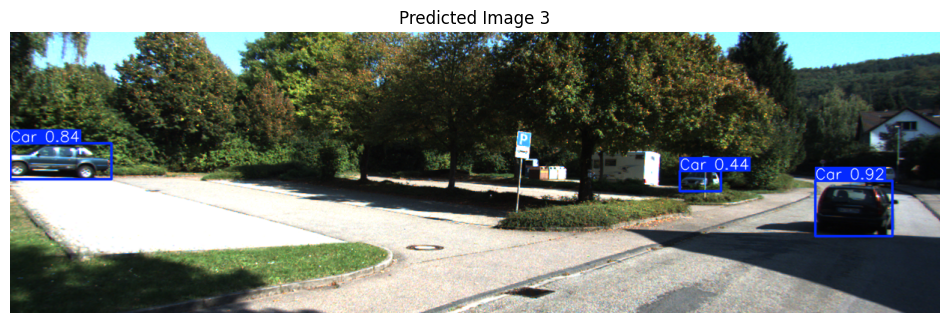

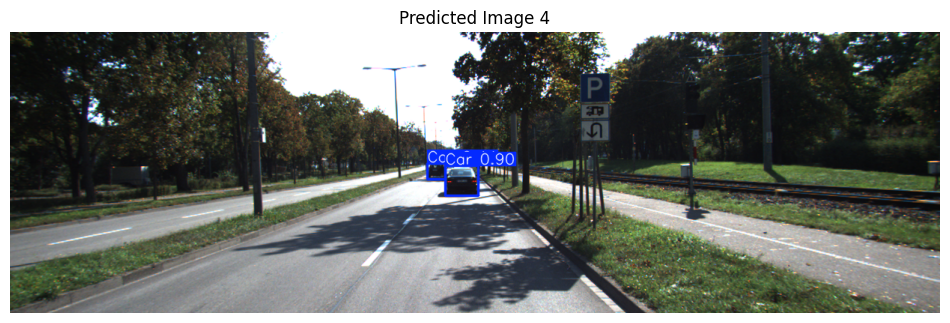

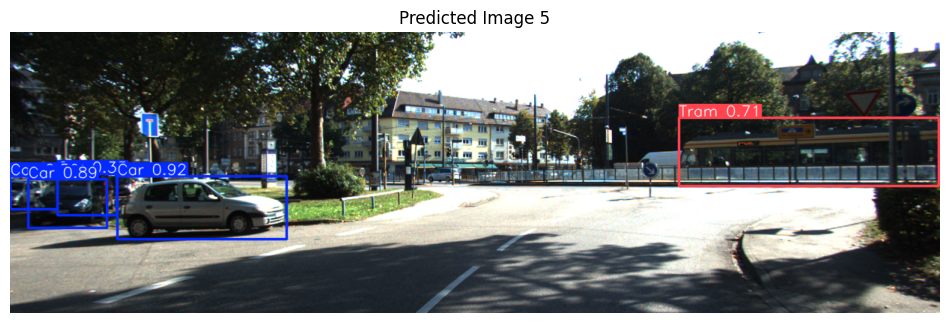

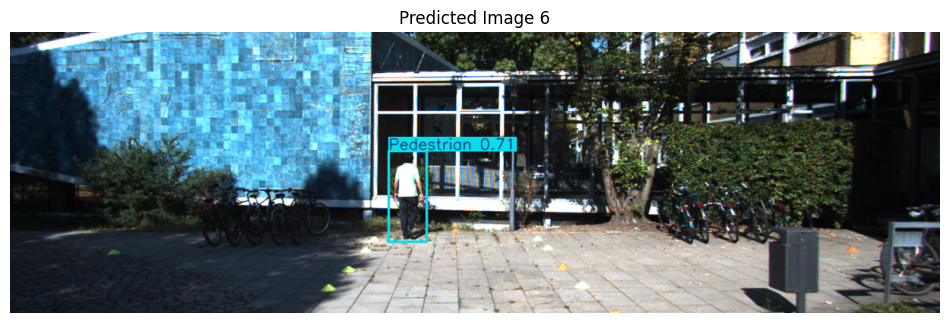

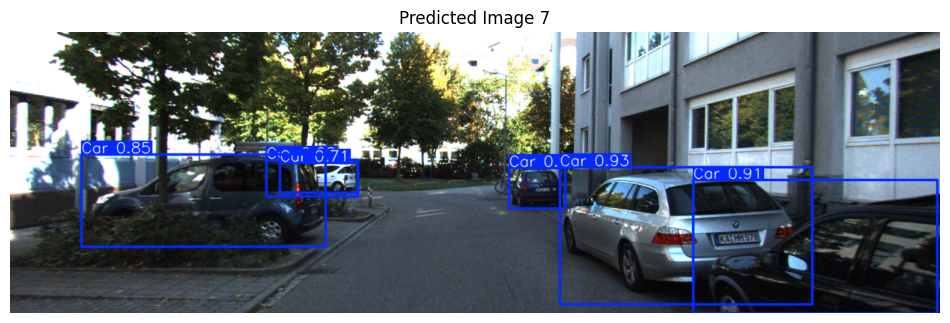

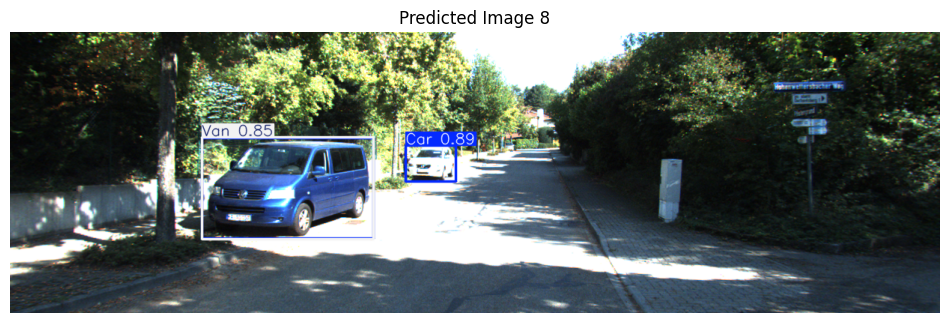

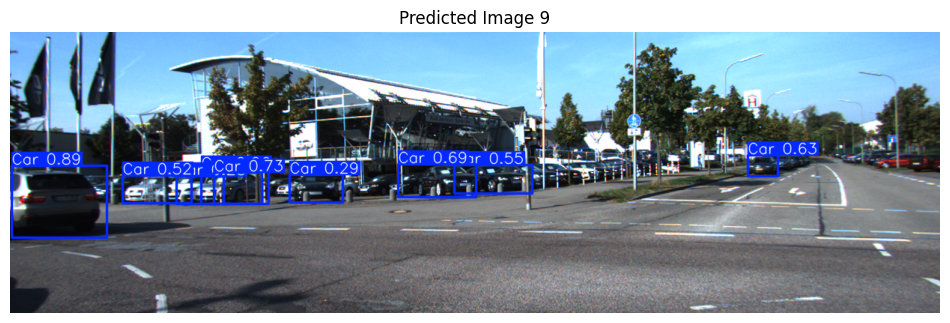

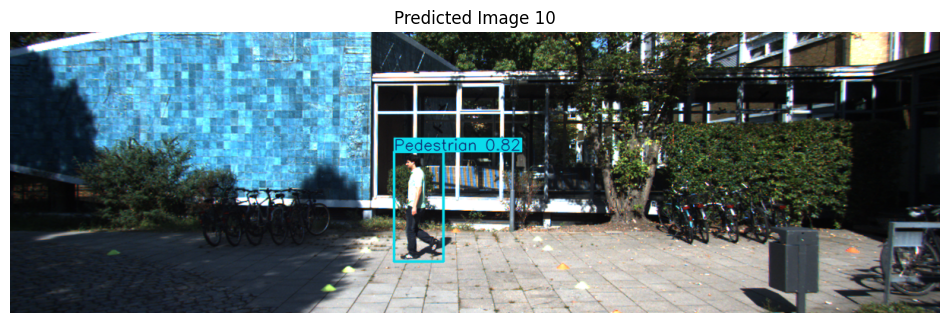

In [192]:
# Path to the predicted images directory
predicted_images_dir = 'KITTI_Object_Detection/exp263'

# Lists all predicted images
predicted_images = [f for f in os.listdir(predicted_images_dir) if f.endswith('.png')]

# Selects 10 random images
random_images = random.sample(predicted_images, 10)

for idx, image_name in enumerate(random_images):
    # Loads the predicted images
    image_path = os.path.join(predicted_images_dir, image_name)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Image {idx + 1}")
    plt.axis('off')

    plt.show()
